# Random Forest Classifier Juypter Notebook File
### Used for predicting protein enrichment [1] or depletion [0]

1. **Mount Google Drive** (if using Colab Notebooks), or download entire repository with data files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import statements

In [ ]:
!pip install biopython # otherwise the data_prep_functions will not be imported!
!pip install scikit-learn==1.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 32.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0


In [ ]:
from google.colab import drive
import os
import sys

drive.mount('/content/drive', force_remount=True)
data_prep_path = '/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/'
sys.path.append(data_prep_path)

from data_prep_functions import *

import threading
import pandas as pd
import numpy as np
import seaborn as sns
import pprint
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, classification_report, r2_score, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.feature_selection import RFE, RFECV, f_classif

Mounted at /content/drive
test! updated 'scorer' function


### Link to proteomic data file

In [ ]:
# final product after Data_Consolidation.ipynb
excel_files = ['/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/df_Bov Swiss Intensity _original.xlsx']

Find smallest value in 'Abundance_Controls' column, use to replace any instance of zero in column. Save to 'post_clean_up_dfs' folder.

In [ ]:
# Iterate over each Excel file
for file in excel_files:
    # Read the Excel file into a DataFrame
    df = pd.read_excel(file, header=0)

    # Get the minimum control value
    Min_Control = df['Abundance_Controls'].drop_duplicates().nsmallest(2).iloc[-1]
    # Replace 0 values in 'Abundance_Controls' column with the second-smallest value
    df['Abundance_Controls'].replace(0, Min_Control, inplace=True)

    # Filter out rows with abundance values below zero
    Min_Abundance = df['Abundance'].drop_duplicates().nsmallest(2).iloc[-1]
    df = df[df['Abundance'] >= Min_Abundance]

    # Extract the filename without extension
    file_name = os.path.splitext(os.path.basename(file))[0]

    # Specify the output file path with the current filename included
    # saving to the post-processed df RFC subfolder
    output_file_path = os.path.join('/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/post_clean_up_dfs/RFC/', f'{file_name}.xlsx')
    df.to_excel(output_file_path, index=False)
    print(file_name)

<ipython-input-5-9bb084efd60f>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Abundance_Controls'].replace(0, Min_Control, inplace=True)


df_Bov Swiss Intensity _original


Added target value for classification to entire dataset
Classifier needs a target value at a threshold level; create 'binary_target' column.

In [ ]:
file_name = 'Bov SP Intensity'
# link to cleaned df (from cell 5 in this notebook)
data_file_path = '/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/post_clean_up_dfs/RFC/df_Bov Swiss Intensity _original.xlsx'

df = pd.read_excel(data_file_path, header=0)
thresh = 1

# Find the second-smallest value in the 'Abundance_Controls' column
Min_Abund = df['Abundance_Controls'].drop_duplicates().nsmallest(2).iloc[-1]

# Replace 0 values in 'Abundance_Controls' column with the second-smallest value
df['Abundance_Controls'].replace(0, Min_Abund, inplace=True)

# Calculate 'Enrich' column as log2 ratio of 'Abundance' and 'Abundance_Controls' columns
df['Enrich'] = np.log2(df['Abundance'] / df['Abundance_Controls'])
print(df['Enrich'].head())

# Create 'binary_target' column based on 'Enrich' and 'thresh' threshold
df['binary_target'] = df['Enrich'].apply(lambda t: 1 if t >= thresh else 0)
print(df['binary_target'].head())

version = 'original' # USER INPUT NEEDED: change as needed
output_file_path = (f'/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/post_clean_up_dfs/RFC/RFC_converted_df/{file_name}_{version}.xlsx')
df.to_excel(output_file_path, index=False)

<ipython-input-6-664c624e3321>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Abundance_Controls'].replace(0, Min_Abund, inplace=True)


0    6.748849
1    0.762688
2    0.163364
3   -2.428926
4    9.628504
Name: Enrich, dtype: float64
0    1
1    0
2    0
3    0
4    1
Name: binary_target, dtype: int64


Split the cleaned data (from above code cell) into training and testing data splits and save.

In [ ]:
total_data = '/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/post_clean_up_dfs/RFC/RFC_converted_df/Bov SP Intensity_original.xlsx'
df = pd.read_excel(total_data)

# Perform a 90/10 train-test split
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

train_file_path = '/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/post_clean_up_dfs/RFC/RFC_converted_df/train_df_Bov SP Intensity_original.xlsx'
train_df.to_excel(train_file_path, index=False)

test_file_path = '/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/post_clean_up_dfs/RFC/RFC_converted_df/test_df_Bov SP Intensity_original.xlsx'
test_df.to_excel(test_file_path, index=False)


ANOVA analysis and selected feature plotting functions.

In [ ]:
def calculate_anova(X, y):
    f_values, p_values = f_classif(X, y)
    return f_values, p_values

def rank_features_by_anova(X, y, feature_names):
    full_name_dict = {
          'Abundance_Controls' : 'Protein Abundance in FBS',
          'frac_aa_A': '% Amino Acid - Alanine (A)',
          'frac_aa_C': '% Amino Acid - Cysteine (C)',
          'frac_aa_D': '% Amino Acid - Aspartic Acid (D)',
          'frac_aa_E': '% Amino Acid - Glutamic Acid (E)',
          'frac_aa_F': '% Amino Acid - Phenylalanine (F)',
          'frac_aa_G': '% Amino Acid - Glycine (G)',
          'frac_aa_H': '% Amino Acid - Histidine (H)',
          'frac_aa_I': '% Amino Acid - Isoleucine (I)',
          'frac_aa_K': '% Amino Acid - Lysine (K)',
          'frac_aa_L': '% Amino Acid - Leucine (L)',
          'frac_aa_M': '% Amino Acid - Methionine (M)',
          'frac_aa_N': '% Amino Acid - Asparagine (N)',
          'frac_aa_P': '% Amino Acid - Proline (P)',
          'frac_aa_Q': '% Amino Acid - Glutamine (Q)',
          'frac_aa_R': '% Amino Acid - Arginine (R)',
          'frac_aa_S': '% Amino Acid - Serine (S)',
          'frac_aa_T': '% Amino Acid - Threonine (T)',
          'frac_aa_V': '% Amino Acid - Valine (V)',
          'frac_aa_W': '% Amino Acid - Tryptophan (W)',
          'frac_aa_Y': '% Amino Acid - Tyrosine (Y)',
          'gravy': 'GRAVY score',
          'aromaticity': 'Aromaticity',
          'instability_index': 'Instability Index',
          'flexibility_mean': 'Flexibility - Mean',
          'flexibility_std': 'Flexibility - Standard Deviation',
          'flexibility_var': 'Flexibility - Variance',
          'flexibility_max': 'Flexibility - Max',
          'flexibility_min': 'Flexibility - Min',
          'flexibility_median': 'Flexibility - Median',
          'isoelectric_point': 'Isoelectric Point',
          'secondary_structure_fraction_helix': '% Secondary Structure-Associated Amino Acids – Helix',
          'secondary_structure_fraction_turn': '% Secondary Structure-Associated Amino Acids – Turn',
          'secondary_structure_fraction_sheet': '% Secondary Structure-Associated Amino Acids – Sheet',
          'secondary_structure_fraction_disordered': '% Secondary Structure-Associated Amino Acids - Non-Structure Associated',
          'length': 'Length',
          'molecular_weight': 'Molecular Weight',
          'fraction_exposed': '% Amino Acids Exposed',
          'fraction_buried': '% Amino Acids Buried',
          'fraction_exposed_nonpolar_total': '% Exposed Nonpolar Amino Acids / Total Amino Acids',
          'fraction_exposed_nonpolar_exposed': '% Exposed Nonpolar Amino Acids / Total Exposed',
          'fraction_exposed_polar_total': '% Exposed Polar Amino Acids / Total Amino Acids',
          'fraction_exposed_polar_exposed': '% Exposed Polar Amino Acids / Total Exposed',
          'rsa_mean': 'Relative Surface Area (RSA) - Mean',
          'rsa_median': 'Relative Surface Area - Median',
          'rsa_std': 'Relative Surface Area - Standard Deviation',
          'asa_sum': 'Absolute Surface Area (ASA) - Sum',
          'fraction_total_exposed_A': '% Exposed Amino Acid A / Total Amino Acids',
          'fraction_total_exposed_C': '% Exposed Amino Acid C / Total Amino Acids',
          'fraction_total_exposed_D': '% Exposed Amino Acid D / Total Amino Acids',
          'fraction_total_exposed_E': '% Exposed Amino Acid E / Total Amino Acids',
          'fraction_total_exposed_F': '% Exposed Amino Acid F / Total Amino Acids',
          'fraction_total_exposed_G': '% Exposed Amino Acid G / Total Amino Acids',
          'fraction_total_exposed_H': '% Exposed Amino Acid H / Total Amino Acids',
          'fraction_total_exposed_I': '% Exposed Amino Acid I / Total Amino Acids',
          'fraction_total_exposed_K': '% Exposed Amino Acid K / Total Amino Acids',
          'fraction_total_exposed_L': '% Exposed Amino Acid L / Total Amino Acids',
          'fraction_total_exposed_M': '% Exposed Amino Acid M / Total Amino Acids',
          'fraction_total_exposed_N': '% Exposed Amino Acid N / Total Amino Acids',
          'fraction_total_exposed_P': '% Exposed Amino Acid P / Total Amino Acids',
          'fraction_total_exposed_Q': '% Exposed Amino Acid Q / Total Amino Acids',
          'fraction_total_exposed_R': '% Exposed Amino Acid R / Total Amino Acids',
          'fraction_total_exposed_S': '% Exposed Amino Acid S / Total Amino Acids',
          'fraction_total_exposed_T': '% Exposed Amino Acid T / Total Amino Acids',
          'fraction_total_exposed_V': '% Exposed Amino Acid V / Total Amino Acids',
          'fraction_total_exposed_W': '% Exposed Amino Acid W / Total Amino Acids',
          'fraction_total_exposed_Y': '% Exposed Amino Acid Y / Total Amino Acids',
          'fraction_exposed_exposed_A': '% Exposed Amino Acid A / Total Exposed',
          'fraction_exposed_exposed_C': '% Exposed Amino Acid C / Total Exposed',
          'fraction_exposed_exposed_D': '% Exposed Amino Acid D / Total Exposed',
          'fraction_exposed_exposed_E': '% Exposed Amino Acid E / Total Exposed',
          'fraction_exposed_exposed_F': '% Exposed Amino Acid F / Total Exposed',
          'fraction_exposed_exposed_G': '% Exposed Amino Acid G / Total Exposed',
          'fraction_exposed_exposed_H': '% Exposed Amino Acid H / Total Exposed',
          'fraction_exposed_exposed_I': '% Exposed Amino Acid I / Total Exposed',
          'fraction_exposed_exposed_K': '% Exposed Amino Acid K / Total Exposed',
          'fraction_exposed_exposed_L': '% Exposed Amino Acid L / Total Exposed',
          'fraction_exposed_exposed_M': '% Exposed Amino Acid M / Total Exposed',
          'fraction_exposed_exposed_N': '% Exposed Amino Acid N / Total Exposed',
          'fraction_exposed_exposed_P': '% Exposed Amino Acid P / Total Exposed',
          'fraction_exposed_exposed_Q': '% Exposed Amino Acid Q / Total Exposed',
          'fraction_exposed_exposed_R': '% Exposed Amino Acid R / Total Exposed',
          'fraction_exposed_exposed_S': '% Exposed Amino Acid S / Total Exposed',
          'fraction_exposed_exposed_T': '% Exposed Amino Acid T / Total Exposed',
          'fraction_exposed_exposed_V': '% Exposed Amino Acid V / Total Exposed',
          'fraction_exposed_exposed_W': '% Exposed Amino Acid W / Total Exposed',
          'fraction_exposed_exposed_Y': '% Exposed Amino Acid Y / Total Exposed',
          'asa_sum_normalized': 'Sum of Absolute Surface Area / Total Mass',
          'nsp_secondary_structure_helix': '% Secondary Structure - Helix',
          'nsp_secondary_structure_sheet': '% Secondary Structure - Sheet',
          'nsp_secondary_structure_coiled': '% Secondary Structure - Coil',
          'nsp_disordered': '% Secondary Structure - Disordered',
          'Zeta Potential': 'Zeta Potential',
          'Core Material': 'NP Core Material',
          'Surface_Ligand': 'Surface Functionalization',
          'Dtem': 'NP Diameter (TEM)',
          'Dh_functionalized': 'NP Diameter (hydrodynamic)',
          'NP_incubation Concentration (mg/mL)': 'NP Conc. (mg/mL)',
          'Incubation Concentration (mg/mL)': 'Protein Conc. (mg/mL)'
    }

    f_values, p_values = calculate_anova(X, y)
    # Replace feature_names with full names using the dictionary
    full_feature_names = [full_name_dict.get(name, name) for name in feature_names]

    feature_importances = pd.DataFrame({
        'Feature': full_feature_names,
        'F-Value': f_values,
        'P-Value': p_values
    })

    ranked_features = feature_importances.sort_values(by='F-Value', ascending=False)
    return ranked_features


def plot_top_features(ranked_features, name):
    top_features = ranked_features.head(10)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(top_features['Feature'], top_features['F-Value'], color='black')
    ax.set_xlabel('F-Value', fontweight='bold', color='black')
    ax.set_title(f'Top 10 Features Ranked by ANOVA for Bovine Swiss-Prot Intensity', fontweight='bold', color='black')
    plt.gca().invert_yaxis()
    plt.show()

## RFECV for RFC model
### Run to determine selected features for classifier

Best Features Names: ['Abundance_Controls', 'Length', 'Mass', 'frac_aa_C', 'frac_aa_F', 'frac_aa_L', 'frac_aa_M', 'frac_aa_R', 'frac_aa_T', 'molecular_weight', 'flexibility_min', 'secondary_structure_fraction_sheet', 'secondary_structure_fraction_disordered', 'gravy', 'fraction_exposed_nonpolar_exposed', 'fraction_exposed_polar_exposed', 'asa_sum', 'fraction_exposed_exposed_C', 'fraction_exposed_exposed_M', 'fraction_exposed_exposed_P', 'fraction_exposed_exposed_R', 'fraction_exposed_exposed_S', 'fraction_exposed_exposed_T', 'fraction_exposed_exposed_Y', 'nsp_secondary_structure_sheet', 'nsp_secondary_structure_helix', 'Zeta Potential', 'Surface_Ligand', 'Dtem', 'Dh_functionalized', 'Incubation Concentration (mg/ml)']
['Abundance_Controls', 'Length', 'Mass', 'frac_aa_C', 'frac_aa_F', 'frac_aa_L', 'frac_aa_M', 'frac_aa_R', 'frac_aa_T', 'molecular_weight', 'flexibility_min', 'secondary_structure_fraction_sheet', 'secondary_structure_fraction_disordered', 'gravy', 'fraction_exposed_nonpol

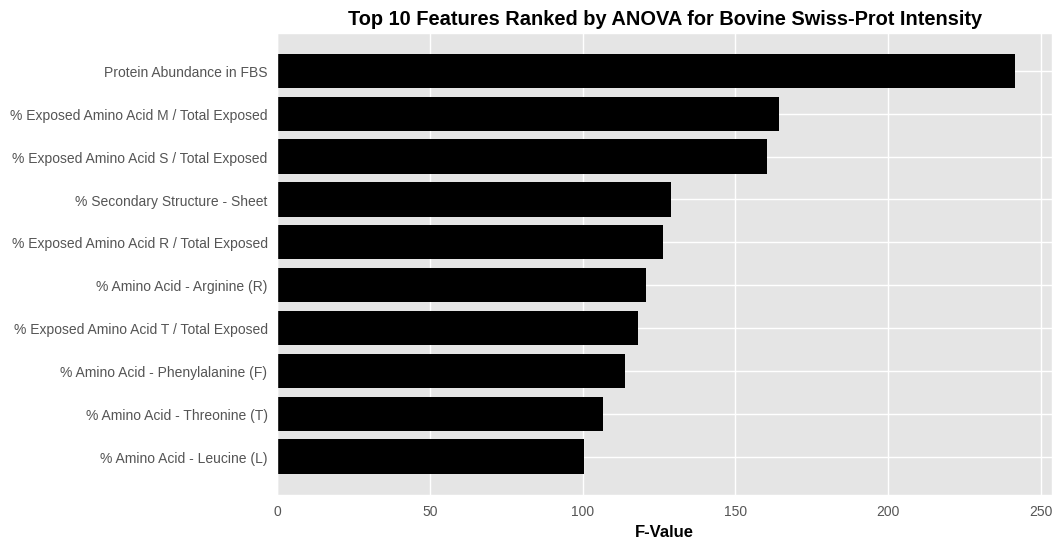

                                   Feature     F-Value       P-Value
0                 Protein Abundance in FBS  241.600768  1.943953e-52
18  % Exposed Amino Acid M / Total Exposed  164.124315  1.302445e-36
21  % Exposed Amino Acid S / Total Exposed  160.481131  7.403073e-36
24           % Secondary Structure - Sheet  128.942829  2.781044e-29
20  % Exposed Amino Acid R / Total Exposed  126.400755  9.495695e-29
7              % Amino Acid - Arginine (R)  120.845655  1.395675e-27
22  % Exposed Amino Acid T / Total Exposed  117.987437  5.576292e-27
4         % Amino Acid - Phenylalanine (F)  113.847604  4.157627e-26
8             % Amino Acid - Threonine (T)  106.502346  1.480718e-24
5               % Amino Acid - Leucine (L)  100.287211  3.069134e-23
Results saved to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/df_RFC_RFECV_Bov SP Intensity_original.csv


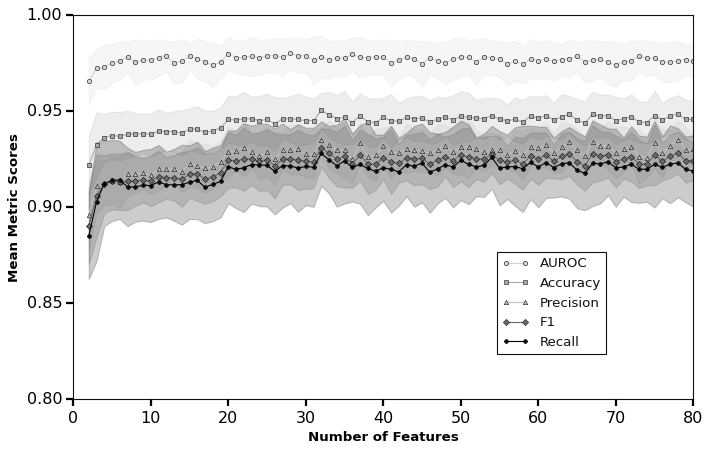

In [ ]:
# Function to process the training file
def process_file(train_df, name):
    # Copy 'binary_target' column to be used as the label for classification
    label_df = train_df['binary_target'].copy()
    y_label = np.ravel(label_df)

    # Remove columns in df that should not be considered as potential features in RFE & RFECV
    columns_to_drop = [col for col in ['Abundance', 'NPUNID', 'Entry', 'Sequence', 'Sample_num', 'Raw_FileID',
                                       'Ligands', 'Enrich', 'binary_target', 'NPID'] if col in train_df.columns]
    df_original = train_df.copy()
    train_df.drop(columns=columns_to_drop, inplace=True)

    identifier = 'accuracy'
    keep_columns = ['Abundance', 'NPUNID', 'Entry', 'binary_target']

    # Define number of folds for cross-validation
    n_splits = 10
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Initialize a RandomForestClassifier model with 100 estimators
    model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Define the range of features to select
    max_features = train_df.shape[1]
    min_features = 1

    current_score = float(-1)
    best_features = None

    df_full_results = pd.DataFrame({
        "Number of features": [],
        "Accuracy": [],
        "Accuracy std": [],
        "Precision": [],
        "Precision std": [],
        "Recall": [],
        "Recall std": [],
        "F1": [],
        "F1 std": [],
        "AUROC": [],
        "AUROC std": [],
        "List of features": [],
        "Combined Score": []
    })

    # Loop through each number of features
    for n_features in range(max_features, min_features, -1):
        accuracies, precisions, recalls, f1s, aurocs = [], [], [], [], []

        # Make a dictionary with feature name keys
        feat_dict = {key: 0 for key in train_df.columns}

        for train_index, test_index in kf.split(train_df):
            X_train, X_test = train_df.iloc[train_index], train_df.iloc[test_index]
            y_train, y_test = y_label[train_index], y_label[test_index]

            # Train the classifier
            model.fit(X_train, y_train)

            # Get predictions for evaluation
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]  # Assuming binary classification

            # Evaluate on validation set
            accuracies.append(model.score(X_test, y_test))
            precisions.append(precision_score(y_test, y_pred, average='macro', zero_division=0))
            recalls.append(recall_score(y_test, y_pred, average='macro', zero_division=0))
            f1s.append(f1_score(y_test, y_pred, average='macro'))
            aurocs.append(roc_auc_score(y_test, y_pred_proba))

            # During each iteration, each feature will get an importance
            for idx, feature in enumerate(train_df.columns):
                feat_dict[feature] += model.feature_importances_[idx]

        # Calculate average of all metrics across all folds
        avg_accuracy, std_accuracy = np.mean(accuracies), np.std(accuracies)
        avg_precision, std_precision = np.mean(precisions), np.std(precisions)
        avg_recall, std_recall = np.mean(recalls), np.std(recalls)
        avg_f1, std_f1 = np.mean(f1s), np.std(f1s)
        avg_auroc, std_auroc = np.mean(aurocs), np.std(aurocs)

        # Record the results
        combined_score = avg_accuracy - std_accuracy - (n_features / 5000)
        df_full_results.loc[len(df_full_results)] = {
            'Number of features': n_features,
            'Accuracy': avg_accuracy, 'Accuracy std': std_accuracy,
            'Precision': avg_precision, 'Precision std': std_precision,
            'Recall': avg_recall, 'Recall std': std_recall,
            'F1': avg_f1, 'F1 std': std_f1,
            'AUROC': avg_auroc, 'AUROC std': std_auroc,
            'List of features': ", ".join(train_df.columns),
            'Combined Score': combined_score
        }

        # Drop the feature with the lowest importance sum
        train_df = train_df[[key for key in feat_dict if key != min(feat_dict, key=feat_dict.get)]]

        if combined_score > current_score:
            current_score = combined_score
            best_features = train_df.columns.tolist()

    print("Best Features Names:", best_features)

    # Save RFECV results and scores
    df_full_results.to_csv(f'/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/RFECV_RFC_results_{name}_{identifier}_original.csv', index=False)

    feat_list = best_features + keep_columns
    print(feat_list)

    # Run Scorer function to determine feature importance and metrics for each DataFrame
    df_best = df_original[feat_list].copy()
    output_dir = '/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/Bovine Swiss Intensity Training'
    RFC_Scores, feats = scorer_RFC(df_best[best_features], y_label, model, identifier, 10, output_dir)
    feats.to_excel(f'/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/Feats_RFECV_RFC_{name}_{identifier}_original.xlsx', index=False)

    # Save DataFrame with the necessary labeling columns that were previously dropped
    df_RFECV = df_original[feat_list].copy()
    df_RFECV.to_excel(f'/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/df_RFECV_RFC_{name}_{identifier}_original.xlsx', index=False)

    # Feature importance normalization
    feature_importances = model.feature_importances_
    normalized_importances = 100.0 * (feature_importances / feature_importances.sum())
    feature_importance_df = pd.DataFrame({'Feature': best_features, 'Importance': normalized_importances})
    print(feature_importance_df)

    # Rank features by ANOVA
    ranked_features = rank_features_by_anova(df_best[best_features], y_label, best_features)
    top_10_features = ranked_features.head(10)

    # Save the ranked features to a CSV file
    top_10_features.to_csv(f'/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/ANOVA_top_features_{name}_original.csv')

    # Plot top features
    plot_top_features(top_10_features, name)
    print(top_10_features)

    # Save results to file
    output_file_path = f'/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/df_RFC_RFECV_Bov SP Intensity_original.csv'
    df_full_results.to_csv(output_file_path, index=False)
    print(f'Results saved to {output_file_path}')

    # Plot RFECV results
    plt.style.use('classic')
    fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')

    metrics = ['AUROC', 'Accuracy', 'Precision', 'F1', 'Recall']
    std_metrics = ['AUROC std', 'Accuracy std', 'Precision std', 'F1 std', 'Recall std']
    colors = ['lightgrey', 'darkgrey', 'silver', 'dimgray', 'black']
    markers = ['o', 's', '^', 'D', 'P']

    for metric, std, color, marker in zip(metrics, std_metrics, colors, markers):
        mean_values = df_full_results[metric].values
        std_devs = df_full_results[std].values
        n_features = df_full_results['Number of features'].values

        ax.plot(n_features, mean_values, label=metric, color=color, marker=marker, markersize=4)
        ax.fill_between(n_features, mean_values - std_devs, mean_values + std_devs, color=color, alpha=0.2)

    ax.set_xlabel('Number of Features', fontweight='bold', color='black')
    ax.set_ylabel('Mean Metric Scores', fontweight='bold', color='black')
    ax.set_ylim([0.80, 1.00])
    plt.xlim(left=0, right=80)  # Adjust this limit based on your dataset
    ax.legend(loc='lower right', fontsize='medium', bbox_to_anchor=(0.87, 0.1), borderaxespad=0.5, frameon=True)
    ax.tick_params(axis='both', which='both', direction='out',
                   length=6, width=2, colors='black',
                   labelsize='large', labelcolor='black',
                   bottom=True, top=False, left=True, right=False)
    ax.grid(False)

    plt.savefig(f'/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/RFECV_plot_{name}_original.png')
    plt.savefig(f'/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/FECV_plot_{name}_original.svg')
    plt.show()
    plt.close()

# Call the function with the cleaned training data
train_df = pd.read_excel('/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/post_clean_up_dfs/RFC/RFC_converted_df/train_df_Bov SP Intensity_original.xlsx')
process_file(train_df, "Bov SP Intensity training_data")

## Predicting on Test Data Split
### Link to previously split testing
Link Excel file from RFECV section: **df_RFECV_RFC_{name}**
to only use features in predictions selected through model training (selected features correspond to columns in df)

Accuracy: 0.9546827794561934
Precision: 0.944962962962963
Recall: 0.9342828224407171
F1 Score: 0.9394549112858972
AUROC: 0.9779496818970503


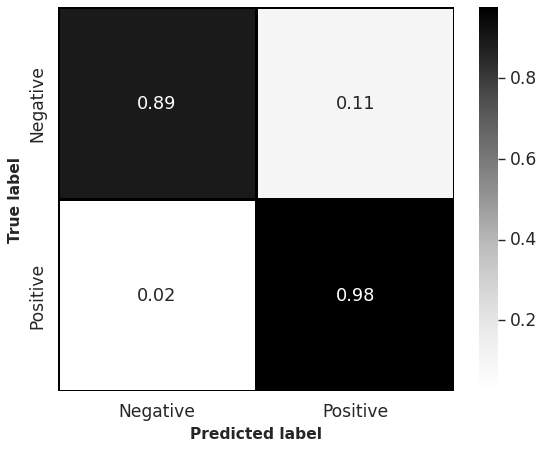

In [ ]:
# generated excel file with 'accuracy' in the name
selected_features_df = '/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/df_RFECV_RFC_Bov SP Intensity training_data_accuracy_original.xlsx'

testing_df = '/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/post_clean_up_dfs/RFC/RFC_converted_df/test_df_Bov SP Intensity_original.xlsx'

def plot_confusion_matrix(y_true, y_pred, class_names, name):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # normalize

    plt.figure(figsize=(8, 6))
    # Set the background to white
    plt.gcf().set_facecolor('white')  # Set the figure background to white
    sns.set_style('white')  # Set the seaborn plot style to white
    sns.set(font_scale=1.4)  # for label size
    sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 16}, fmt=".2f", cmap='Greys',
                xticklabels=class_names, yticklabels=class_names, cbar=True, linewidths=1, linecolor='black')
    plt.ylabel('True label', fontweight='bold', fontsize=14)
    plt.xlabel('Predicted label', fontweight='bold', fontsize=14)
    #plt.title('Normalized Confusion Matrix:\nBovine Swiss-Prot Intensity', fontweight='bold', fontsize=16)
    #plt.savefig(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity/Confusion_Matrix_{name}.png')
    plt.show()


def predict_file(train_file, test_file, name):
    # Initialize RandomForestClassifier
    model = RandomForestClassifier(n_estimators=100, random_state = 42)

    # Read the training and test DataFrames
    df_train = pd.read_excel(train_file, header=0)
    df_test = pd.read_excel(test_file, header=0)

    # Define the target variable for training and testing (binary_target)
    y_train = df_train['binary_target'].astype(int)
    y_test = df_test['binary_target'].astype(int)

    # Drop unnecessary columns in both train and test sets
    columns_to_drop = ['Abundance', 'NPUNID', 'Entry', 'binary_target']
    df_train.drop(columns=columns_to_drop, inplace=True, errors='ignore')
    df_test.drop(columns=columns_to_drop, inplace=True, errors='ignore')

    # Ensure the test data has the same features as the training data
    selected_features = df_train.columns.tolist()  # The features used for training
    df_test = df_test[selected_features]  # Filter the test set to include only the selected features

    # Train the RandomForestClassifier on the training data
    model.fit(df_train, y_train)

    # Predict on the test set
    y_pred = model.predict(df_test)
    y_pred_proba = model.predict_proba(df_test)

    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro')
    auroc = roc_auc_score(y_test, y_pred_proba[:, 1]) if len(np.unique(y_test)) == 2 else roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

    # Print evaluation metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("AUROC:", auroc)

    # Call the function to plot the confusion matrix
    plot_confusion_matrix(y_test, y_pred, ['Negative', 'Positive'], name)

    # Feature Importance Plot
    # feature_importances = model.feature_importances_
    # sorted_idx = np.argsort(feature_importances)
    # plt.barh(df_train.columns[sorted_idx], feature_importances[sorted_idx], color='grey')
    # plt.xlabel('Feature Importance')
    # plt.title('Feature Importance for RFC Model')
    # plt.savefig(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/RFC_v2/Feature_Importance_{name}_v3.png')
    # plt.show()

    # Save evaluation metrics to an Excel file
    metrics = {
        "Accuracy": [accuracy],
        "Precision": [precision],
        "Recall": [recall],
        "F1 Score": [f1],
        "AUROC": [auroc]
    }
    metrics_df = pd.DataFrame(metrics)
    metrics_df.to_excel(f'/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/Metrics_{name}_original.xlsx', index=False)






predict_file(selected_features_df, testing_df, 'Bov SP Intensity')


## NP-Specific Predictions


   Abundance_Controls  Length    Mass  frac_aa_C  frac_aa_F  frac_aa_L  \
0            0.000318     683   74408   0.016105   0.023426   0.130307   
1            0.435971     145   15859   0.013793   0.068966   0.137931   
2            0.002369     783   87467   0.006386   0.035760   0.070243   
3            0.028812     843   93090   0.066429   0.041518   0.075919   
4            0.000040     932  104541   0.068670   0.041845   0.071888   

   frac_aa_M  frac_aa_R  frac_aa_T  molecular_weight  ...  \
0   0.024890   0.048316   0.065886        74406.7079  ...   
1   0.006897   0.041379   0.020690        15859.0250  ...   
2   0.014049   0.052363   0.066411        87465.9780  ...   
3   0.011862   0.048636   0.047450        93089.3405  ...   
4   0.012876   0.059013   0.050429       104539.9561  ...   

   nsp_secondary_structure_helix  Zeta Potential  Surface_Ligand  Dtem  \
0                          0.259             -63               1   200   
1                          0.779        

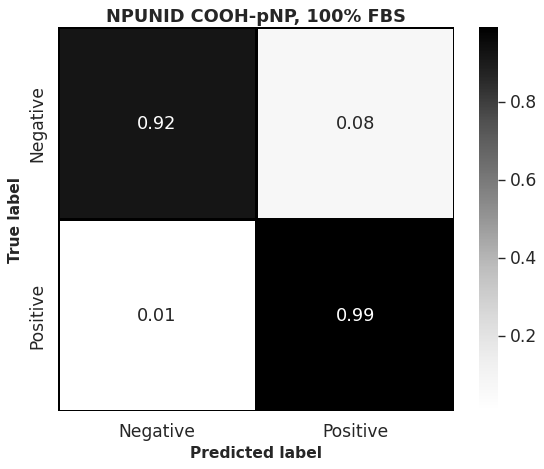

Accuracy: 0.930635838150289
Precision: 0.884529602595296
Recall: 0.9012907321201862
F1 Score: 0.8925465838509317
AUROC: 0.9820143884892086


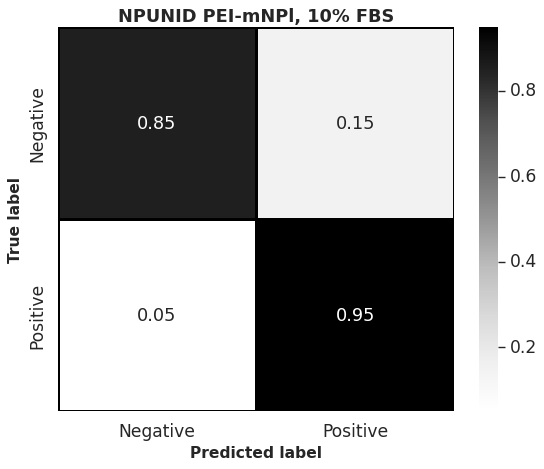

Accuracy: 0.9516129032258065
Precision: 0.8913584637268848
Recall: 0.9580645161290322
F1 Score: 0.9199311235471372
AUROC: 0.9920915712799167


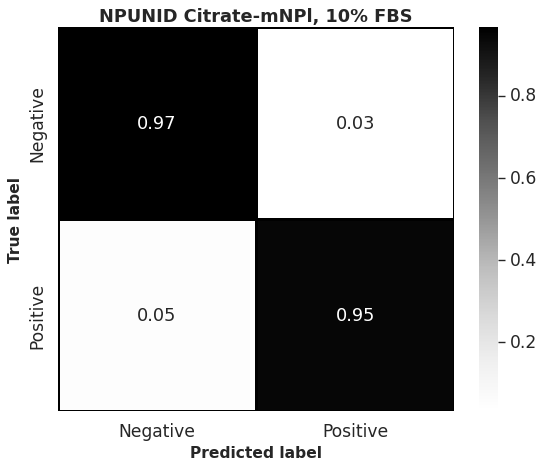

Accuracy: 0.9519230769230769
Precision: 0.9367011564211808
Recall: 0.9367011564211808
F1 Score: 0.9367011564211808
AUROC: 0.9791235544735241


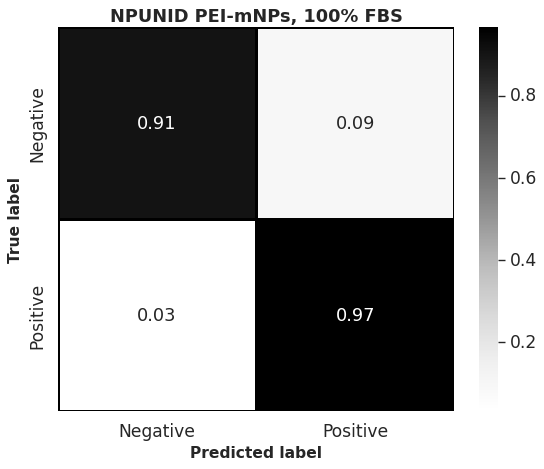

Accuracy: 0.9576719576719577
Precision: 0.9578900709219859
Recall: 0.9350084222346996
F1 Score: 0.945611510791367
AUROC: 0.967363840539023


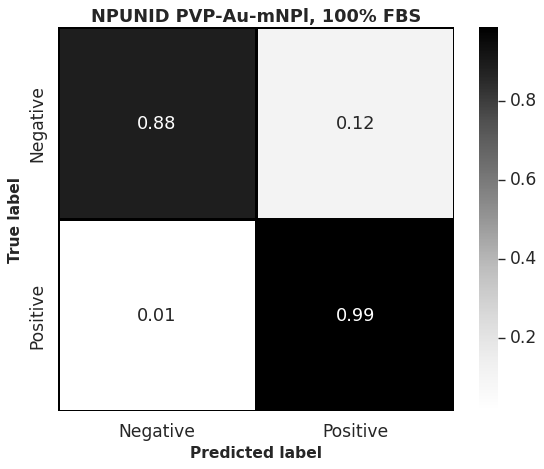

Accuracy: 0.9336734693877551
Precision: 0.9297498309668695
Recall: 0.9053571428571429
F1 Score: 0.9164453189047385
AUROC: 0.9528061224489797


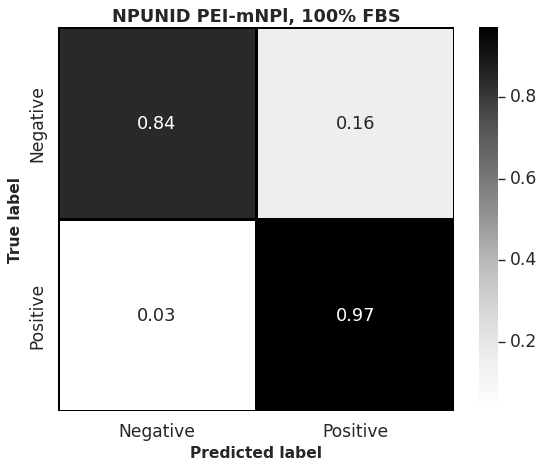

Accuracy: 0.92
Precision: 0.9042370231394622
Recall: 0.9042370231394622
F1 Score: 0.9042370231394622
AUROC: 0.982801751094434


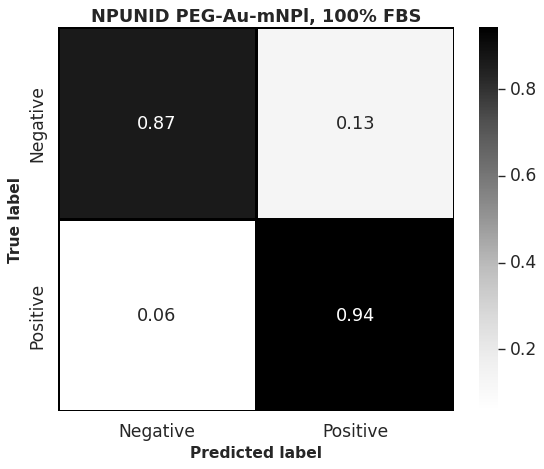

Accuracy: 0.9526315789473684
Precision: 0.8995367689635205
Recall: 0.93125
F1 Score: 0.914375844975214
AUROC: 0.9833333333333334


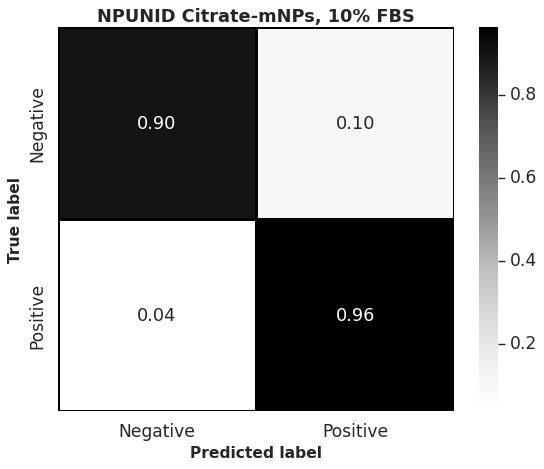

Accuracy: 0.97
Precision: 0.9698784249682453
Recall: 0.9293649477698558
F1 Score: 0.948051948051948
AUROC: 0.9887249212402587


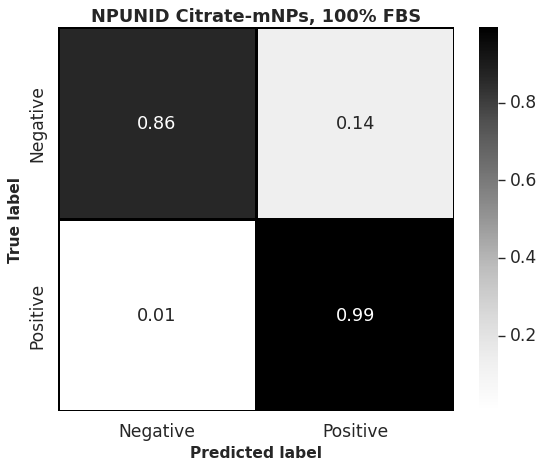

Accuracy: 0.9692307692307692
Precision: 0.978494623655914
Recall: 0.9512195121951219
F1 Score: 0.9633699633699633
AUROC: 0.9787613044669773


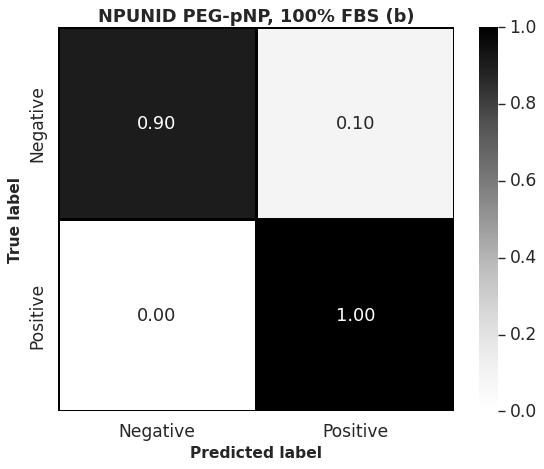

Accuracy: 0.95
Precision: 0.9385612843470207
Recall: 0.949667616334283
F1 Score: 0.9437500000000001
AUROC: 0.9879708768597657


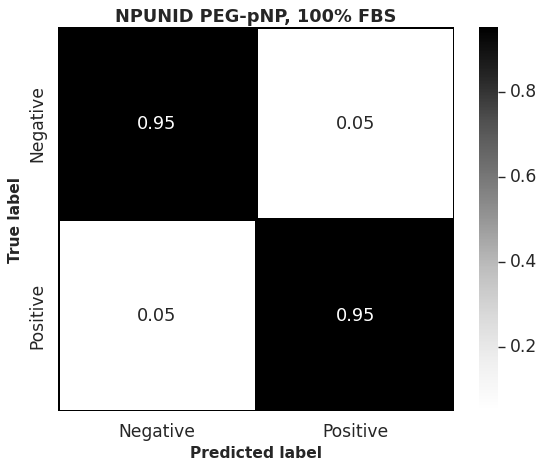

Accuracy: 0.923469387755102
Precision: 0.8944145026947574
Recall: 0.8733766233766234
F1 Score: 0.8832916517803977
AUROC: 0.9635126777983921


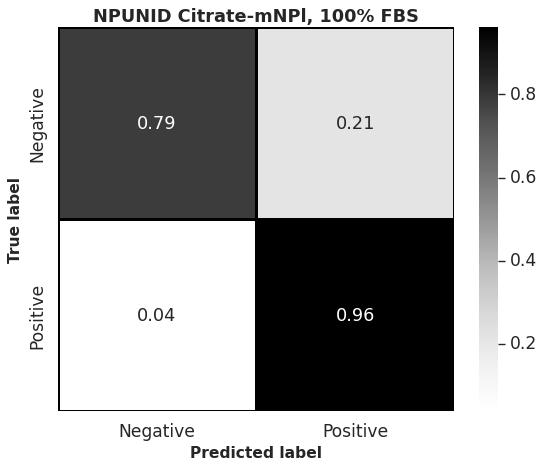

Accuracy: 0.9641025641025641
Precision: 0.9602968176254589
Recall: 0.9389407645170703
F1 Score: 0.9490462503266266
AUROC: 0.9919025386635543


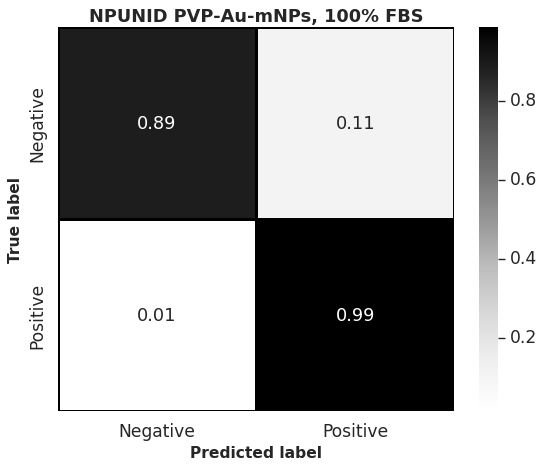

Accuracy: 0.9166666666666666
Precision: 0.9249037227214377
Recall: 0.895933014354067
F1 Score: 0.9073788206236493
AUROC: 0.9557416267942584


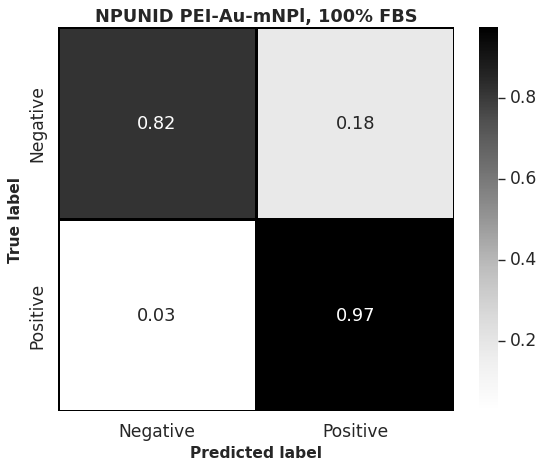

Accuracy: 0.9510869565217391
Precision: 0.9010454217736121
Recall: 0.9465181617499498
F1 Score: 0.921468203158344
AUROC: 0.9875576961669676


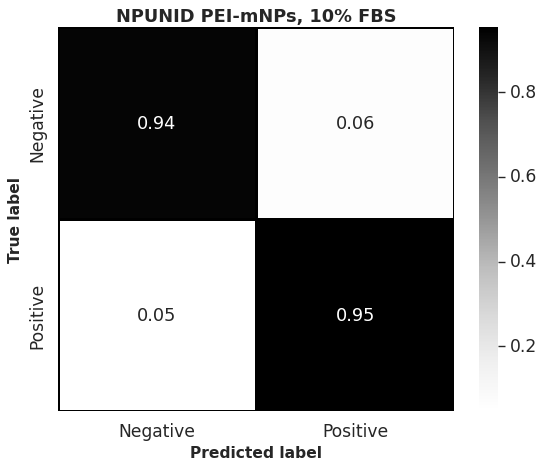

Accuracy: 0.9375
Precision: 0.9137187230371009
Recall: 0.9137187230371009
F1 Score: 0.9137187230371009
AUROC: 0.9812338222605694


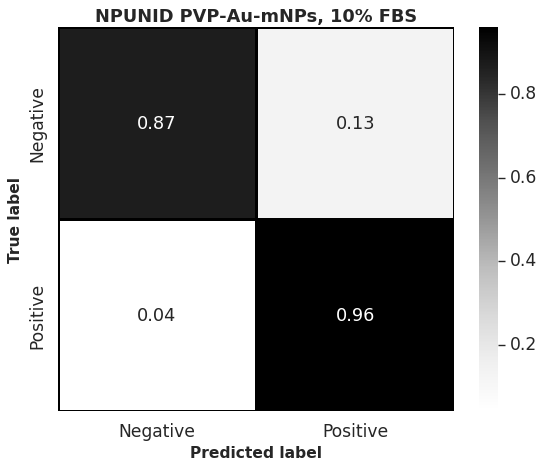

Accuracy: 0.9555555555555556
Precision: 0.9618055555555556
Recall: 0.9130434782608696
F1 Score: 0.9345335515548281
AUROC: 0.9855072463768116


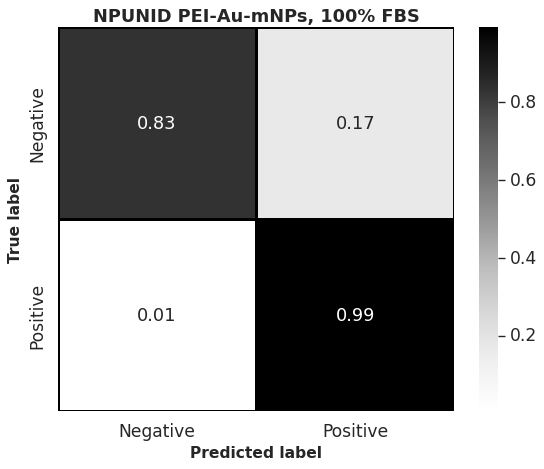

Accuracy: 0.9367088607594937
Precision: 0.9072966507177034
Recall: 0.9328389830508474
F1 Score: 0.9189244663382594
AUROC: 0.9899364406779662


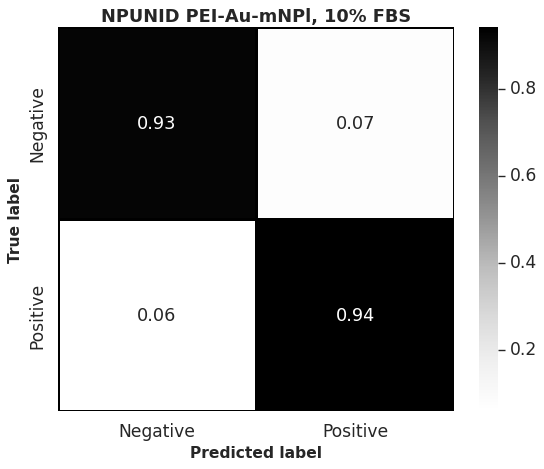

Accuracy: 0.953757225433526
Precision: 0.9509141494435612
Recall: 0.9192535107169253
F1 Score: 0.9337925755836204
AUROC: 0.9904841093865484


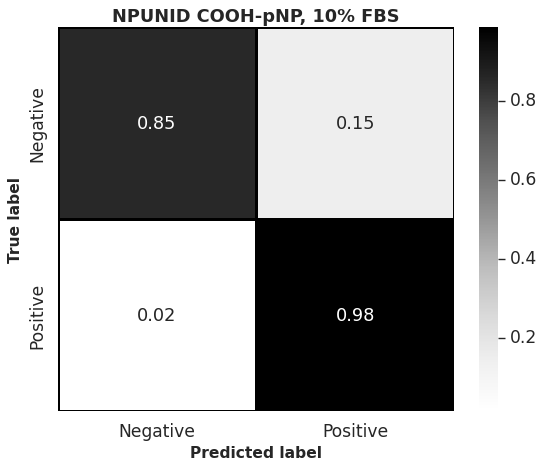

Empty DataFrame
Columns: []
Index: []


In [ ]:
npunid_to_full_name = {
    17: "COOH-pNP, 10% FBS",
    18: "COOH-pNP, 100% FBS",
    19: "Citrate-mNPs, 10% FBS",
    20: "Citrate-mNPl, 10% FBS",
    21: "PEI-mNPs, 10% FBS",
    22: "PEI-mNPl, 10% FBS",
    23: "PVP-Au-mNPl, 100% FBS",
    24: "PVP-Au-mNPs, 10% FBS",
    25: "PVP-Au-mNPs, 100% FBS",
    26: "Citrate-mNPl, 100% FBS",
    27: "PEI-mNPl, 100% FBS",
    28: "Citrate-mNPs, 100% FBS",
    29: "PEI-mNPs, 100% FBS",
    30: "PEI-Au-mNPl, 10% FBS",
    31: "PEG-Au-mNPl, 100% FBS",
    32: "PEI-Au-mNPl, 100% FBS",
    33: "PEI-Au-mNPs, 100% FBS",
    34: "PEG-pNP, 100% FBS",
    35: "PEG-pNP, 100% FBS (b)"
}

def plot_confusion_matrix(y_true, y_pred, class_names, name):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # normalize

    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.4)  # for label size
    sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 16}, fmt=".2f", cmap='Greys',
                xticklabels=class_names, yticklabels=class_names, cbar=True, linewidths=1, linecolor='black')
    plt.ylabel('True label', fontweight='bold', fontsize=14)
    plt.xlabel('Predicted label', fontweight='bold', fontsize=14)
    plt.title(f'NPUNID {name}', fontweight='bold', fontsize=16)
    #plt.savefig(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity/Confusion_Matrix_{name}.png')
    plt.show()

def predict_nanoparticles(df_train, df_test, name):
    # Initialize RandomForestClassifier
    model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Define the target variable for training and testing (binary_target)
    y_train = df_train['binary_target'].astype(int)
    y_test = df_test['binary_target'].astype(int)

    # Drop unnecessary columns in both train and test sets
    columns_to_drop = ['Abundance', 'NPUNID', 'Entry', 'binary_target']
    df_train.drop(columns=columns_to_drop, inplace=True, errors='ignore')
    df_test.drop(columns=columns_to_drop, inplace=True, errors='ignore')

    # Ensure the test data has the same features as the training data
    selected_features = df_train.columns.tolist()  # The features used for training
    df_test = df_test[selected_features]  # Filter the test set to include only the selected features

    # Train the RandomForestClassifier on the training data
    model.fit(df_train[selected_features], y_train)

    # Predict on the test set
    y_pred = model.predict(df_test)
    y_pred_proba = model.predict_proba(df_test)

    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro')
    auroc = roc_auc_score(y_test, y_pred_proba[:, 1]) if len(np.unique(y_test)) == 2 else roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

    # Print evaluation metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("AUROC:", auroc)

    # Call the function to plot the confusion matrix
    plot_confusion_matrix(y_test, y_pred, ['Negative', 'Positive'], name)

    # Feature Importance Plot
    # feature_importances = model.feature_importances_
    # sorted_idx = np.argsort(feature_importances)
    # plt.barh(df_train.columns[sorted_idx], feature_importances[sorted_idx], color='grey')
    # plt.xlabel('Feature Importance')
    # plt.title(f'Feature Importance for {name}')
    # plt.savefig(f'/content/drive/MyDrive/Predicting_the_Protein_Corona_Vijgen/Output_DataFrames/RFC/Bovine Swiss Intensity/Feature_Importance_{name}_v3.png')
    # plt.show()

    # Save evaluation metrics to an Excel file
    metrics = {
        "Accuracy": [accuracy],
        "Precision": [precision],
        "Recall": [recall],
        "F1 Score": [f1],
        "AUROC": [auroc]
    }

    metrics_df = pd.DataFrame(metrics)
    metrics_df.to_excel(f'/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/Metrics_{name}_original.xlsx', index=False)


complete_data = '/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/post_clean_up_dfs/RFC/RFC_converted_df/Bov SP Intensity_original.xlsx'
df = pd.read_excel(complete_data, header=0).copy()

selected_feats_df = '/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/df_RFECV_RFC_Bov SP Intensity training_data_accuracy_original.xlsx'
df_feats = pd.read_excel(selected_feats_df, header=0)

df_modified = df[df_feats.columns.tolist()]
print(df_modified.head())

# Create new evaluation df that will have the results of everything appended to it
full_eval = pd.DataFrame()

# Create a list of all unique NPUNID IDs in current df
np_ids = df_modified['NPUNID'].unique().tolist()
print(np_ids)

for np_id in np_ids:
    # Filter df to only include rows with current NPUNID - test set
    current_np = df_modified.loc[df_modified['NPUNID'] == np_id].copy()
    # Filter df to only include rows without current NPUNID - train set
    temp_df = df_modified.loc[df_modified['NPUNID'] != np_id].copy()

    # Get full sample name
    full_name = npunid_to_full_name.get(np_id, f'ID: {np_id}')

    # Train RFC model to make predictions on current NPUNID entry
    eval = predict_nanoparticles(temp_df, current_np, full_name)

    # Append the test results to the full evaluation DataFrame
    full_eval = pd.concat([full_eval, eval], ignore_index=True)

print(full_eval.head())



# NP-specific Abundance Class Predictions

   Abundance_Controls  Length    Mass  frac_aa_C  frac_aa_F  frac_aa_L  \
0            0.000318     683   74408   0.016105   0.023426   0.130307   
1            0.435971     145   15859   0.013793   0.068966   0.137931   
2            0.002369     783   87467   0.006386   0.035760   0.070243   
3            0.028812     843   93090   0.066429   0.041518   0.075919   
4            0.000040     932  104541   0.068670   0.041845   0.071888   

   frac_aa_M  frac_aa_R  frac_aa_T  molecular_weight  ...  \
0   0.024890   0.048316   0.065886        74406.7079  ...   
1   0.006897   0.041379   0.020690        15859.0250  ...   
2   0.014049   0.052363   0.066411        87465.9780  ...   
3   0.011862   0.048636   0.047450        93089.3405  ...   
4   0.012876   0.059013   0.050429       104539.9561  ...   

   nsp_secondary_structure_helix  Zeta Potential  Surface_Ligand  Dtem  \
0                          0.259             -63               1   200   
1                          0.779        

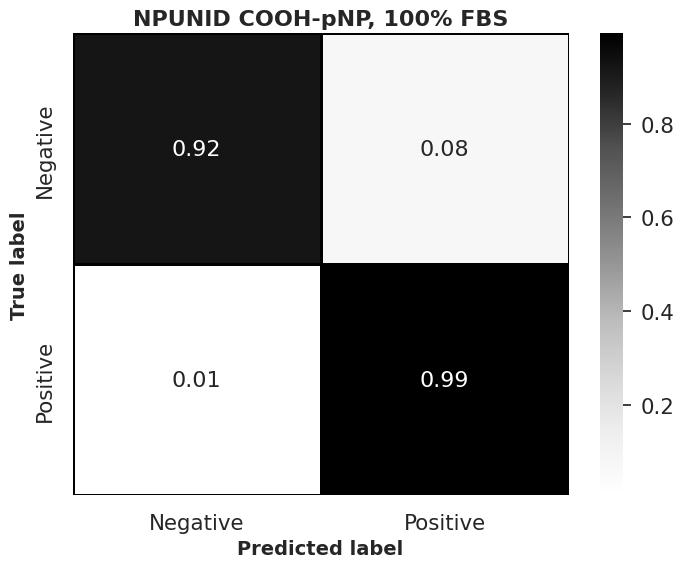

Saved confusion matrix data for PEI-mNPl, 10% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/PEI-mNPl, 10% FBS_confusion_matrix_data.xlsx
Accuracy: 0.930635838150289
Precision: 0.884529602595296
Recall: 0.9012907321201862
F1 Score: 0.8925465838509317
AUROC: 0.9820143884892086


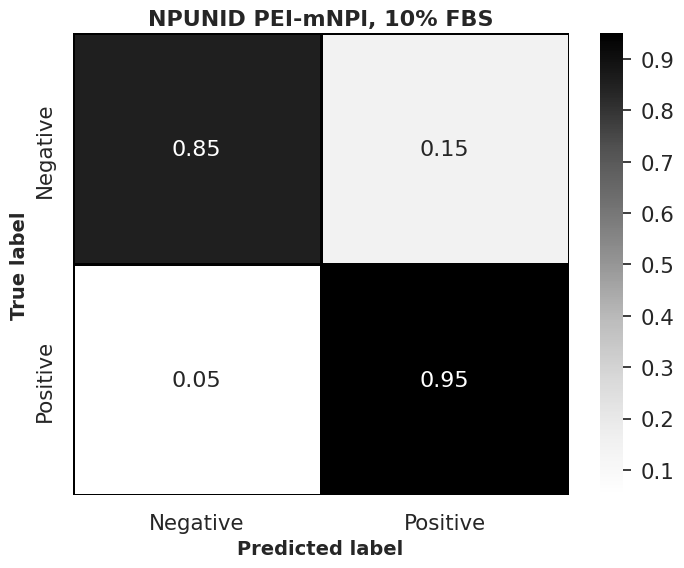

Saved confusion matrix data for Citrate-mNPl, 10% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/Citrate-mNPl, 10% FBS_confusion_matrix_data.xlsx
Accuracy: 0.9516129032258065
Precision: 0.8913584637268848
Recall: 0.9580645161290322
F1 Score: 0.9199311235471372
AUROC: 0.9920915712799167


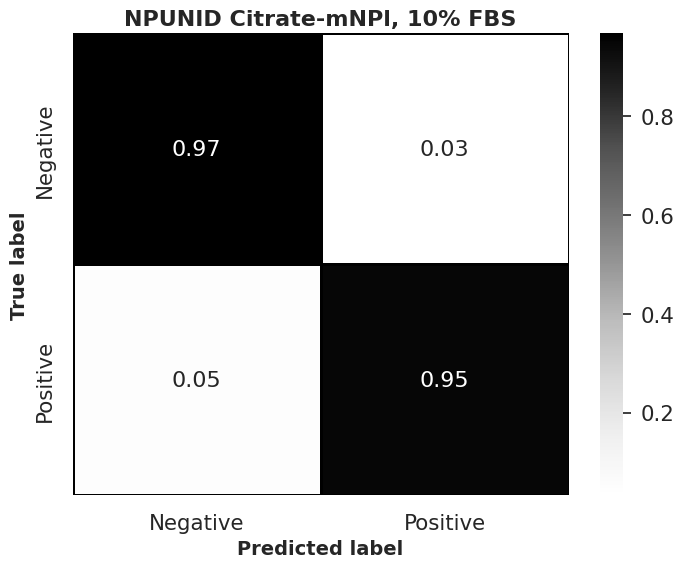

Saved confusion matrix data for PEI-mNPs, 100% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/PEI-mNPs, 100% FBS_confusion_matrix_data.xlsx
Accuracy: 0.9519230769230769
Precision: 0.9367011564211808
Recall: 0.9367011564211808
F1 Score: 0.9367011564211808
AUROC: 0.9791235544735241


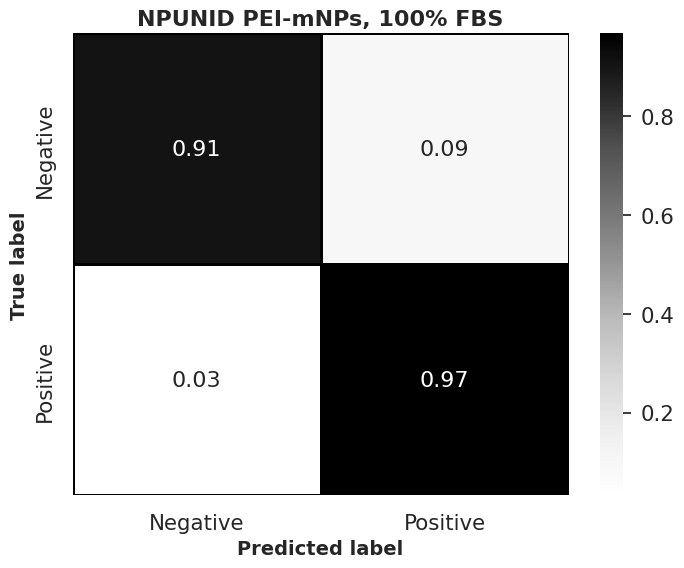

Saved confusion matrix data for PVP-Au-mNPl, 100% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/PVP-Au-mNPl, 100% FBS_confusion_matrix_data.xlsx
Accuracy: 0.9576719576719577
Precision: 0.9578900709219859
Recall: 0.9350084222346996
F1 Score: 0.945611510791367
AUROC: 0.967363840539023


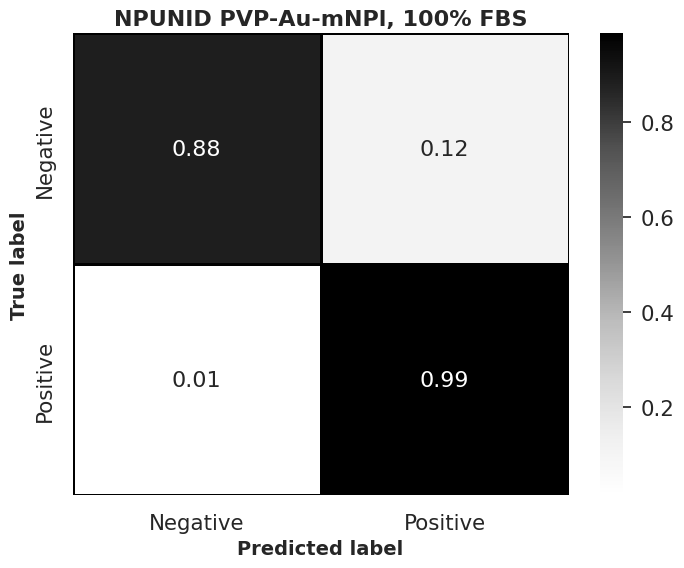

Saved confusion matrix data for PEI-mNPl, 100% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/PEI-mNPl, 100% FBS_confusion_matrix_data.xlsx
Accuracy: 0.9336734693877551
Precision: 0.9297498309668695
Recall: 0.9053571428571429
F1 Score: 0.9164453189047385
AUROC: 0.9528061224489797


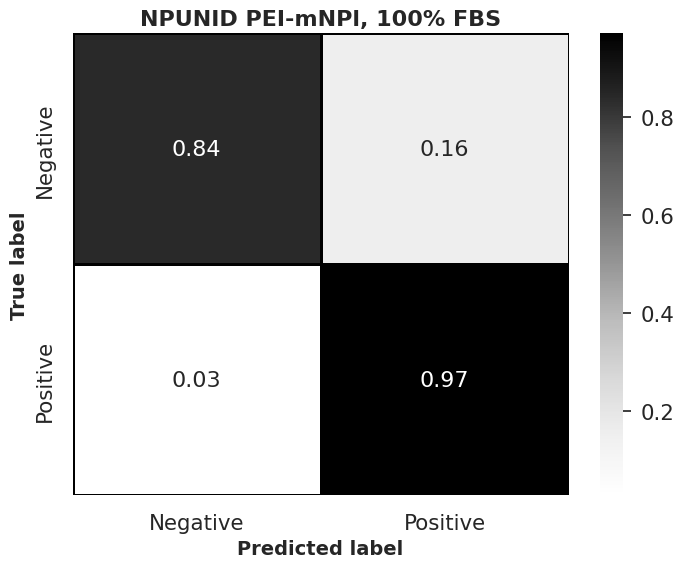

Saved confusion matrix data for PEG-Au-mNPl, 100% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/PEG-Au-mNPl, 100% FBS_confusion_matrix_data.xlsx
Accuracy: 0.92
Precision: 0.9042370231394622
Recall: 0.9042370231394622
F1 Score: 0.9042370231394622
AUROC: 0.982801751094434


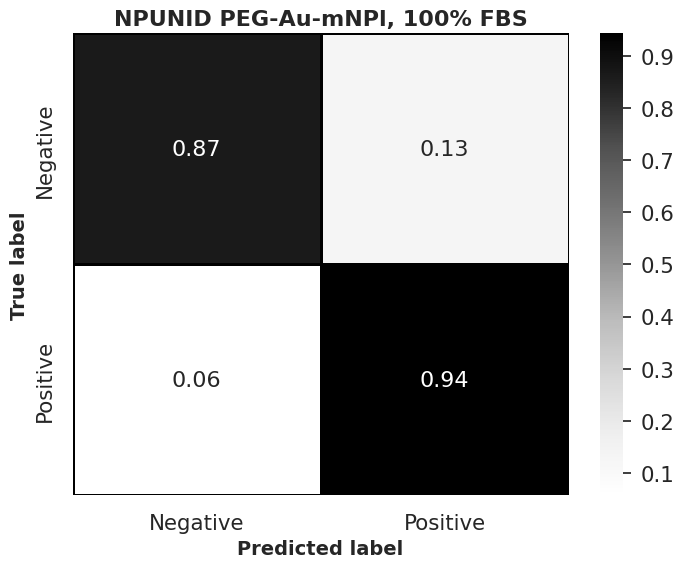

Saved confusion matrix data for Citrate-mNPs, 10% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/Citrate-mNPs, 10% FBS_confusion_matrix_data.xlsx
Accuracy: 0.9526315789473684
Precision: 0.8995367689635205
Recall: 0.93125
F1 Score: 0.914375844975214
AUROC: 0.9833333333333334


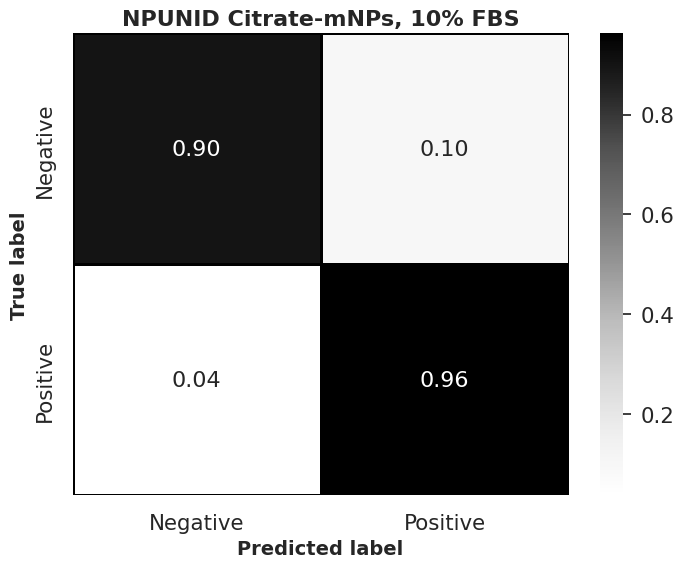

Saved confusion matrix data for Citrate-mNPs, 100% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/Citrate-mNPs, 100% FBS_confusion_matrix_data.xlsx
Accuracy: 0.97
Precision: 0.9698784249682453
Recall: 0.9293649477698558
F1 Score: 0.948051948051948
AUROC: 0.9887249212402587


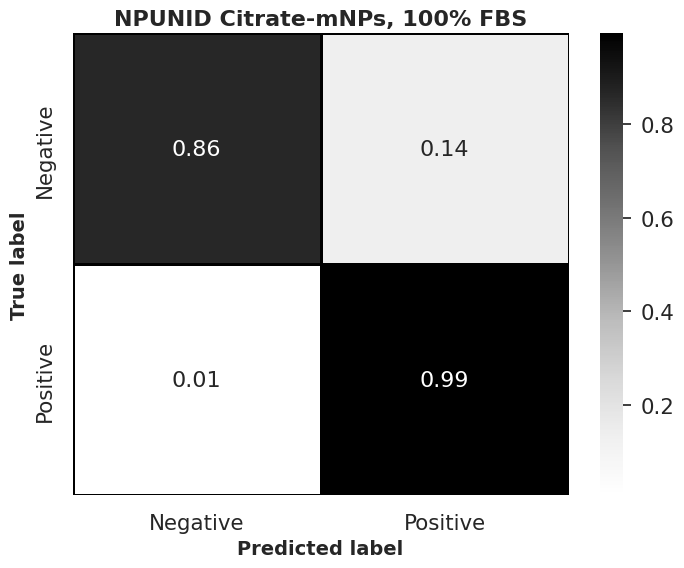

Saved confusion matrix data for PEG-pNP, 100% FBS (b) to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/PEG-pNP, 100% FBS (b)_confusion_matrix_data.xlsx
Accuracy: 0.9692307692307692
Precision: 0.978494623655914
Recall: 0.9512195121951219
F1 Score: 0.9633699633699633
AUROC: 0.9787613044669773


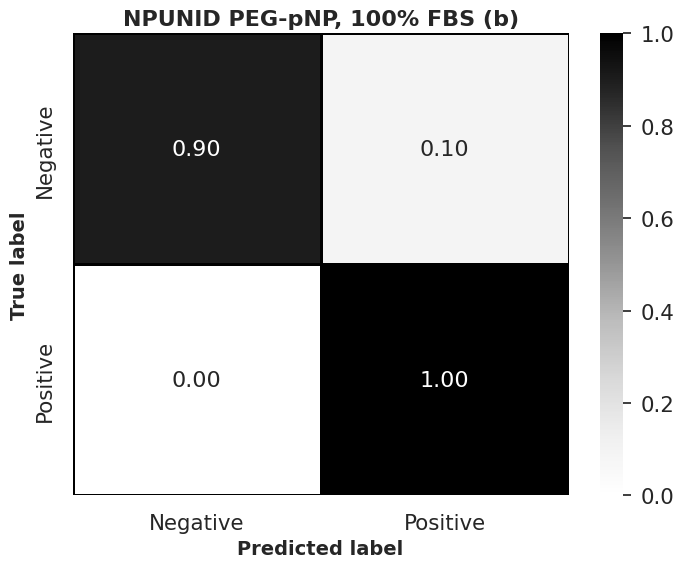

Saved confusion matrix data for PEG-pNP, 100% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/PEG-pNP, 100% FBS_confusion_matrix_data.xlsx
Accuracy: 0.95
Precision: 0.9385612843470207
Recall: 0.949667616334283
F1 Score: 0.9437500000000001
AUROC: 0.9879708768597657


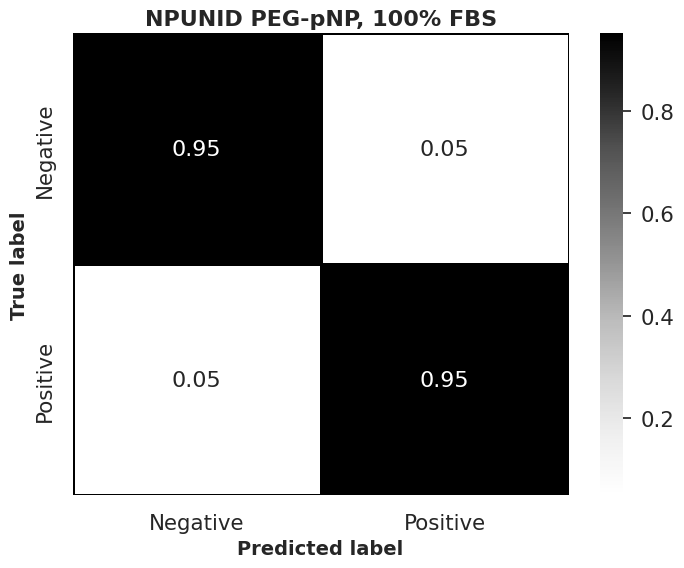

Saved confusion matrix data for Citrate-mNPl, 100% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/Citrate-mNPl, 100% FBS_confusion_matrix_data.xlsx
Accuracy: 0.923469387755102
Precision: 0.8944145026947574
Recall: 0.8733766233766234
F1 Score: 0.8832916517803977
AUROC: 0.9635126777983921


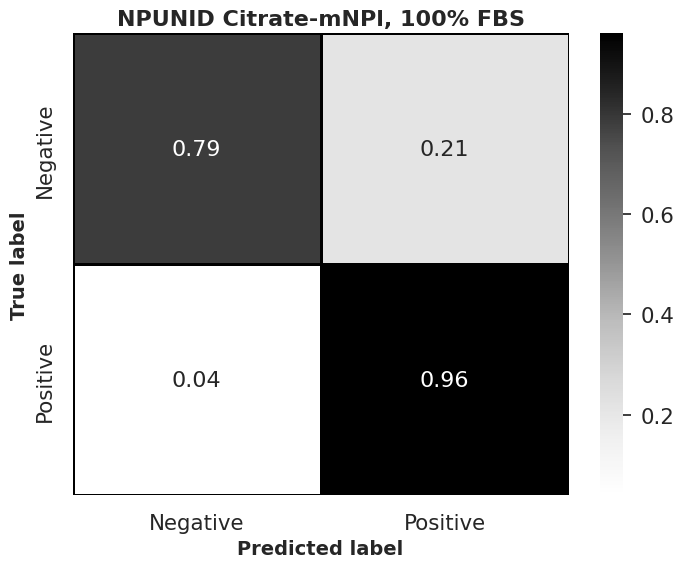

Saved confusion matrix data for PVP-Au-mNPs, 100% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/PVP-Au-mNPs, 100% FBS_confusion_matrix_data.xlsx
Accuracy: 0.9641025641025641
Precision: 0.9602968176254589
Recall: 0.9389407645170703
F1 Score: 0.9490462503266266
AUROC: 0.9919025386635543


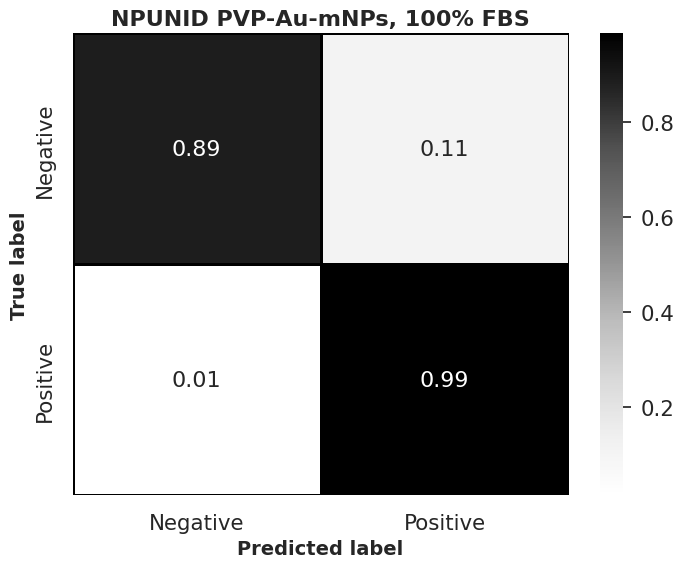

Saved confusion matrix data for PEI-Au-mNPl, 100% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/PEI-Au-mNPl, 100% FBS_confusion_matrix_data.xlsx
Accuracy: 0.9166666666666666
Precision: 0.9249037227214377
Recall: 0.895933014354067
F1 Score: 0.9073788206236493
AUROC: 0.9557416267942584


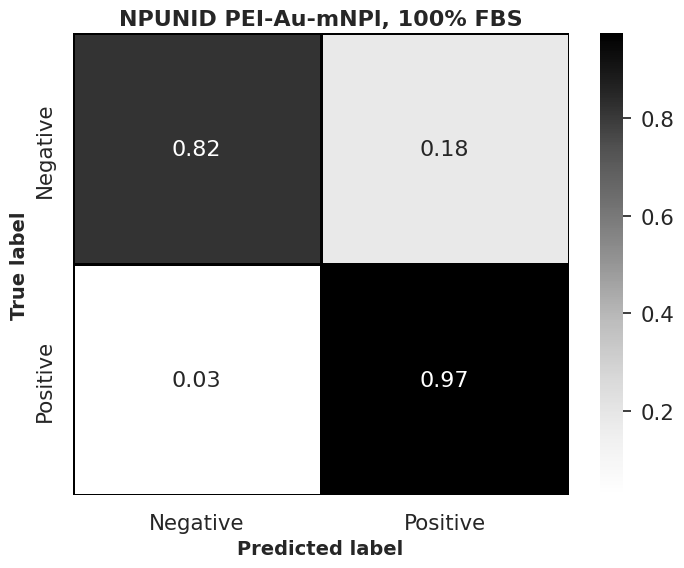

Saved confusion matrix data for PEI-mNPs, 10% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/PEI-mNPs, 10% FBS_confusion_matrix_data.xlsx
Accuracy: 0.9510869565217391
Precision: 0.9010454217736121
Recall: 0.9465181617499498
F1 Score: 0.921468203158344
AUROC: 0.9875576961669676


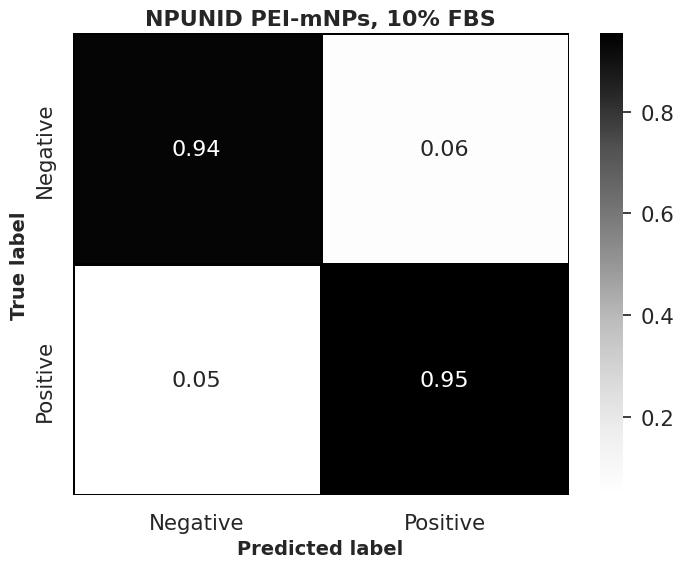

Saved confusion matrix data for PVP-Au-mNPs, 10% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/PVP-Au-mNPs, 10% FBS_confusion_matrix_data.xlsx
Accuracy: 0.9375
Precision: 0.9137187230371009
Recall: 0.9137187230371009
F1 Score: 0.9137187230371009
AUROC: 0.9812338222605694


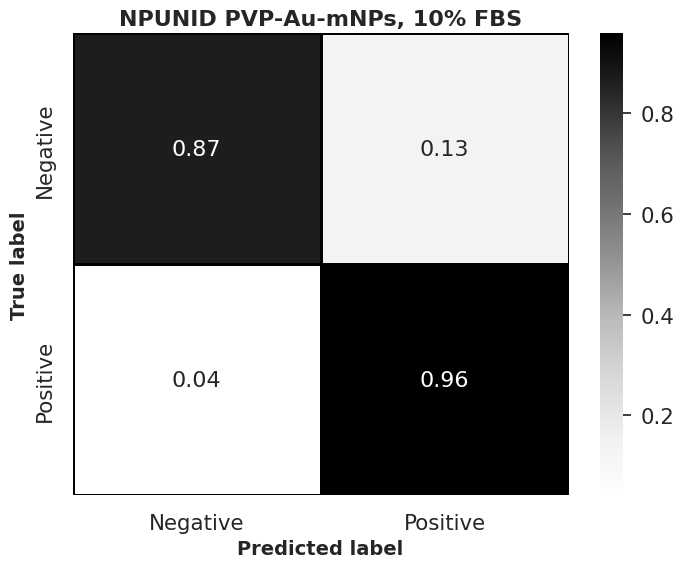

Saved confusion matrix data for PEI-Au-mNPs, 100% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/PEI-Au-mNPs, 100% FBS_confusion_matrix_data.xlsx
Accuracy: 0.9555555555555556
Precision: 0.9618055555555556
Recall: 0.9130434782608696
F1 Score: 0.9345335515548281
AUROC: 0.9855072463768116


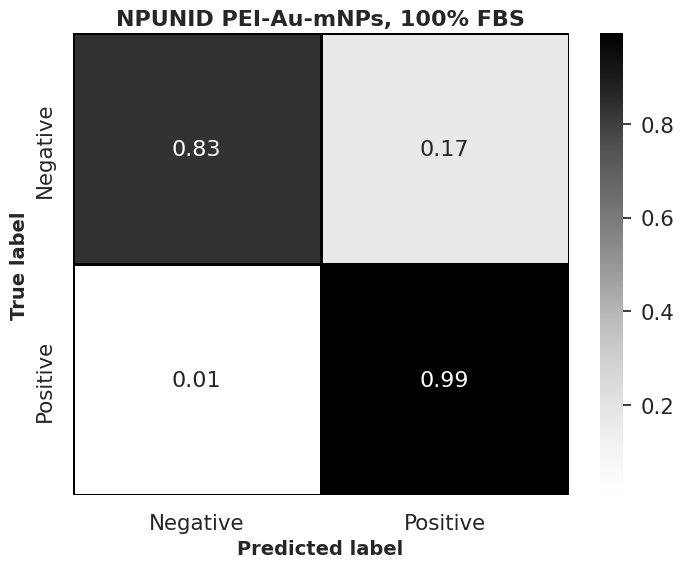

Saved confusion matrix data for PEI-Au-mNPl, 10% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/PEI-Au-mNPl, 10% FBS_confusion_matrix_data.xlsx
Accuracy: 0.9367088607594937
Precision: 0.9072966507177034
Recall: 0.9328389830508474
F1 Score: 0.9189244663382594
AUROC: 0.9899364406779662


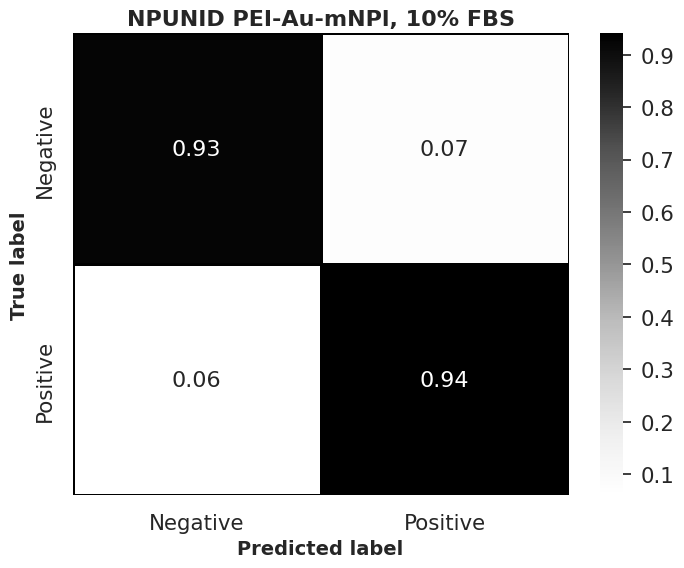

Saved confusion matrix data for COOH-pNP, 10% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/COOH-pNP, 10% FBS_confusion_matrix_data.xlsx
Accuracy: 0.953757225433526
Precision: 0.9509141494435612
Recall: 0.9192535107169253
F1 Score: 0.9337925755836204
AUROC: 0.9904841093865484


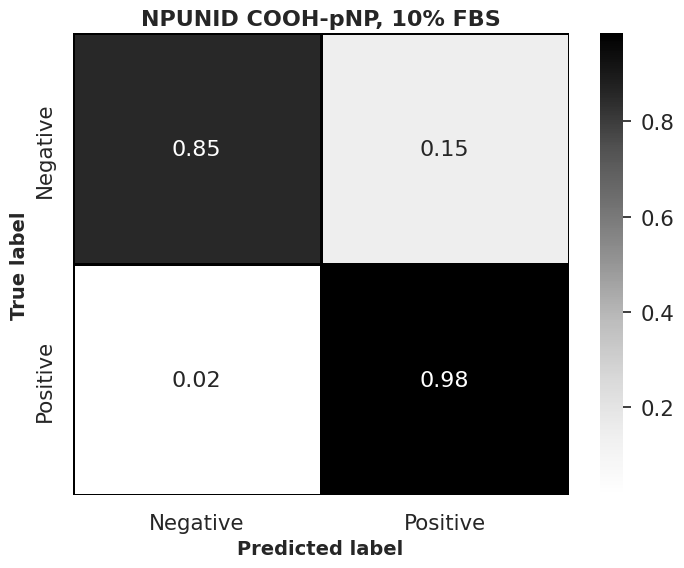

  Protein  True Class  Predicted Class
0  P55906           1                1
1  P52556           1                1
2  P35445           0                0
3  Q3SWW8           1                1
4  Q2KJ33           1                1


In [ ]:
def predict_nanoparticles(df_train, df_test, name):
    # Initialize RandomForestClassifier
    model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Define the target variable for training and testing (binary_target)
    y_train = df_train['binary_target'].astype(int)
    y_test = df_test['binary_target'].astype(int)

    # Drop unnecessary columns in both train and test sets
    # Do NOT drop 'Entry' so it remains available for the output file
    columns_to_drop = ['Abundance', 'NPUNID', 'binary_target']
    df_train.drop(columns=columns_to_drop, inplace=True, errors='ignore')
    df_test.drop(columns=columns_to_drop, inplace=True, errors='ignore')

    # Ensure the test data has the same features as the training data
    # Select only numeric columns for training and testing
    X_train = df_train.select_dtypes(include=[np.number])
    X_test = df_test[X_train.columns]  # Ensure the test set matches the train set features

    # Train the RandomForestClassifier
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Save confusion matrix data
    # The 'Entry' column is included here as 'Protein'
    results = pd.DataFrame({
        'Protein': df_test['Entry'] if 'Entry' in df_test.columns else None,  # Add Entry column as Protein
        'True Class': y_test,
        'Predicted Class': y_pred
    })

    # Save results to an Excel file
    output_file = f"/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/{name}_confusion_matrix_data.xlsx"
    results.to_excel(output_file, index=False)
    print(f"Saved confusion matrix data for {name} to {output_file}")

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro')
    auroc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]) if len(np.unique(y_test)) == 2 else roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"AUROC: {auroc}")

    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred, ['Negative', 'Positive'], name)

    # Return results for further processing
    return results

# Load the input files
complete_data = '/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/post_clean_up_dfs/RFC/RFC_converted_df/Bov SP Intensity_original.xlsx'
df = pd.read_excel(complete_data, header=0).copy()

selected_feats_df = '/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFC/df_RFECV_RFC_Bov SP Intensity training_data_accuracy_original.xlsx'
df_feats = pd.read_excel(selected_feats_df, header=0)

# Ensure NPUNID, Entry, and binary_target are included
required_columns = ['NPUNID', 'Entry', 'binary_target']
df_modified = df[df_feats.columns.tolist() + required_columns]

# Remove duplicate columns if they exist
df_modified = df_modified.loc[:, ~df_modified.columns.duplicated()]

print(df_modified.head())

# Create a new DataFrame for storing results
full_eval = pd.DataFrame()

# Get unique NPUNID values
np_ids = df_modified['NPUNID'].unique().tolist()
print(np_ids)

# Iterate through all unique NPUNID values
for np_id in np_ids:
    # Filter test and train sets
    current_np = df_modified.loc[df_modified['NPUNID'] == np_id].copy()
    temp_df = df_modified.loc[df_modified['NPUNID'] != np_id].copy()

    # Get full sample name
    full_name = npunid_to_full_name.get(np_id, f'ID: {np_id}')

    # Train RFC model to make predictions on current NPUNID entry
    eval = predict_nanoparticles(temp_df, current_np, full_name)

    # Append the test results to the full evaluation DataFrame
    full_eval = pd.concat([full_eval, eval], ignore_index=True)

print(full_eval.head())
